In [176]:
from ipywidgets import interact
import ipywidgets as widgets
import matplotlib.pyplot as plt
from scipy import stats
from scipy import signal
from scipy.io import wavfile
import numpy as np
import seaborn as sns
import os

sns.set_theme()
sns.set_style("darkgrid")

In [4]:
samplerate, data = wavfile.read('sonido-presion/presion_segmento_1.wav')

In [6]:
path = 'sonido-presion/'
files = {i: {'presion': [], 'sonido': []} for i in range(1,4)}

for i,file in enumerate(os.listdir(path)):
  file_name = str(os.path.splitext(file)[0])
  segmento = int(file_name.split('_')[2])
  param = file_name.split('_')[0]

  sample_rate, data = wavfile.read(os.path.join(path, file))
  print(f'La frecuencia de muestreo del segmento {segmento} de {file_name.split("_")[0]} es {sample_rate}. N = {len(data)}')
  files[segmento][param] = data.astype(np.int32)

La frecuencia de muestreo del segmento 1 de presion es 44150. N = 38976
La frecuencia de muestreo del segmento 2 de presion es 44150. N = 43400
La frecuencia de muestreo del segmento 3 de presion es 44150. N = 24472
La frecuencia de muestreo del segmento 1 de sonido es 44150. N = 38976
La frecuencia de muestreo del segmento 2 de sonido es 44150. N = 43400
La frecuencia de muestreo del segmento 3 de sonido es 44150. N = 24472


# Segmento 1

In [8]:
frec_m = 44150
dt_m = 1/frec_m
N  = len(files[1]['presion'])
t_m = np.arange(0, N) * dt_m

print(f'dt muestreo: {dt_m} \n tiempo total de medición {t_m[-1]} s')

dt muestreo: 2.2650056625141562e-05 
 tiempo total de medición 0.8827859569648924 s


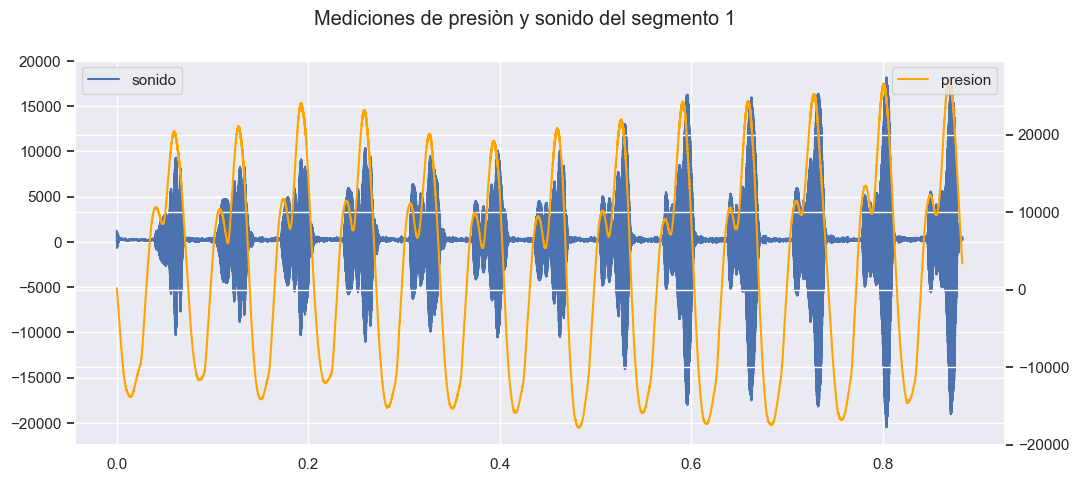

In [12]:


fig,ax = plt.subplots(figsize=(12,5))

ax.plot(t_m,files[1]['sonido'], label = 'sonido')
plt.suptitle('Mediciones de presiòn y sonido del segmento 1')
plt.legend(loc = 0)

ax2=ax.twinx()
ax2.tick_params(axis='both')
ax2.plot(t_m,files[1]['presion'], label = 'presion', color = 'orange')
plt.legend(loc=1)
plt.show()


In [14]:
dt = 1/884000 # este es el dt de la simulación
t = np.arange(0, t_m[-1], dt)

In [16]:
dif = list(set(t).difference(t_m))
intersec = list(set(t_m).intersection(t))
print(len(dif), len(intersec))
#claramente nos son multiplos el uno del otro

780366 17


In [18]:
# la cantidad de puntos que quiero tener:
dt_m/dt * N
print(f'N de la simulacion: {len(t)} \n',f'N de los datos {len(t_m)} \n', f' Tomo de la simulación 1 dato cada {len(t)/len(t_m)}')
# preguntar: no conviene tomar a dt como un multiplo de dt_m ? que sea 20 en vez de 20.01...
len(t)

N de la simulacion: 780383 
 N de los datos 38976 
  Tomo de la simulación 1 dato cada 20.02214183087028


780383

Interpolo $\beta$

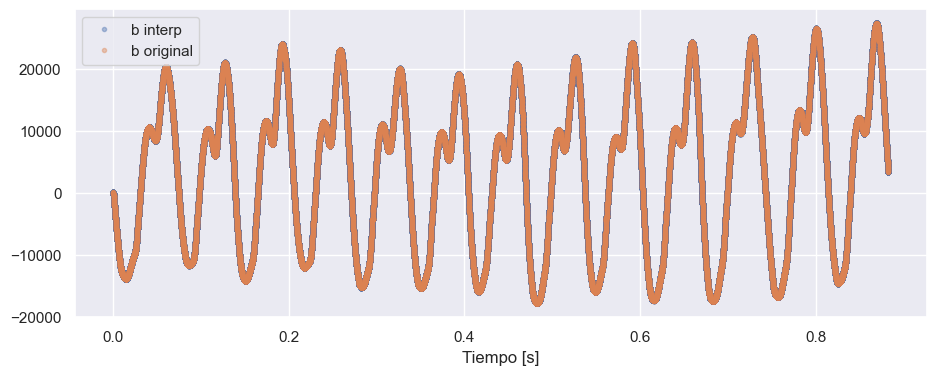

In [24]:
from scipy.interpolate import interp1d
import numpy as np

p = files[1]['presion']
s = files[1]['sonido']

interp_func = interp1d(t_m, p)

b_interpolado = interp_func(np.linspace(0, t_m[-1],len(t) ))
plt.figure(figsize= (11,4))
plt.plot(t,b_interpolado, '.', label = "b interp", alpha = .4)
plt.plot(t_m, p, '.', label = "b original", alpha = .4)
plt.xlabel('Tiempo [s]')
plt.legend()
plt.show()

#### Determino el offset $\beta = p + offset$ tal que los valores de $\beta$ sean negativos cuando el sonido es nulo

In [28]:

def plot1(offset):
    fig,ax = plt.subplots(figsize=(12,5))

    b = p + offset
    ax.plot(t_m,s, label = 'sonido', color = 'blue')
    ax.plot(t_m[b<0],s[b<0],'.', color = 'red')
    ax.plot()
    plt.legend(loc = 0)

    ax2=ax.twinx()
    ax2.tick_params(axis='both')
    ax2.plot(t_m,b, label = "presion")
    ax2.plot(t_m[b<0],b[b<0], color = 'red')
    ax2.axhline(y=0, color='black', linestyle='-')

    plt.legend(loc=1)
    plt.show()

#params
offset = widgets.FloatSlider(value=1000 , min= 0 , max= 16000, step= .5e3, description='offset')

# linkeo el slider con los graficos
output1 = widgets.interactive_output(plot1, {'offset': offset})

# muestro los outputs#
display(offset, output1)


FloatSlider(value=1000.0, description='offset', max=16000.0, step=500.0)

Output()

offset de 9k es razonable (8.5k?)

### Con $\beta$ interpolado ahora corro la simulación.

In [34]:

#funcion del sistema de ecuaciones
def f(X, t, params):
    w, x = X
    k, c, delta, beta = params

    gamma = 1e4 #reescaleo
    mu = 1e5

    f_w = -gamma * k / mu * (x + delta / k)
    f_x = gamma * mu * (w - c * x**3 / mu + beta * x / mu )
    return np.array([f_w,f_x])

#método Runge-Kutta 4
def paso_RK(X, f, t, dt, params, orden=4):
    k1 = f(X, t, params)
    k2 = f(X + k1 * dt / 2, t, params)

    if orden == 2:
        X = X + (k1 + k2) / 2 * dt
    elif orden == 4:
        k3 = f(X + k2 * dt / 2, t, params)
        k4 = f(X + k3 * dt, t, params)
        X = X + (k1 + 2 * (k2 + k3) + k4) / 6 * dt
    return X


In [36]:
#preguntar las ci !!!
x0 = 1
w0 = 0
X0 = np.array([w0, x0])

#parametros
k, c, f0= 1 , 1, 0



In [38]:

colors = ['green','red','black','blue']
N_i = len(t)
b_ = (b_interpolado + 9000)*1e-4 #UNIDADES!!! ese escaleo lo puse para que me den valores razonable de beta
Xs = np.zeros((N_i + 1, 2))
Xs[0] = X0
# Integración
for j in range(N_i):
    params = [k, c, f0, b_[j]]
    Xs[j + 1] = paso_RK(Xs[j], f, t[j], dt, params, 4)


Text(0.5, 0.98, 'Evolución del sistema con $\\beta$ de mediciones')

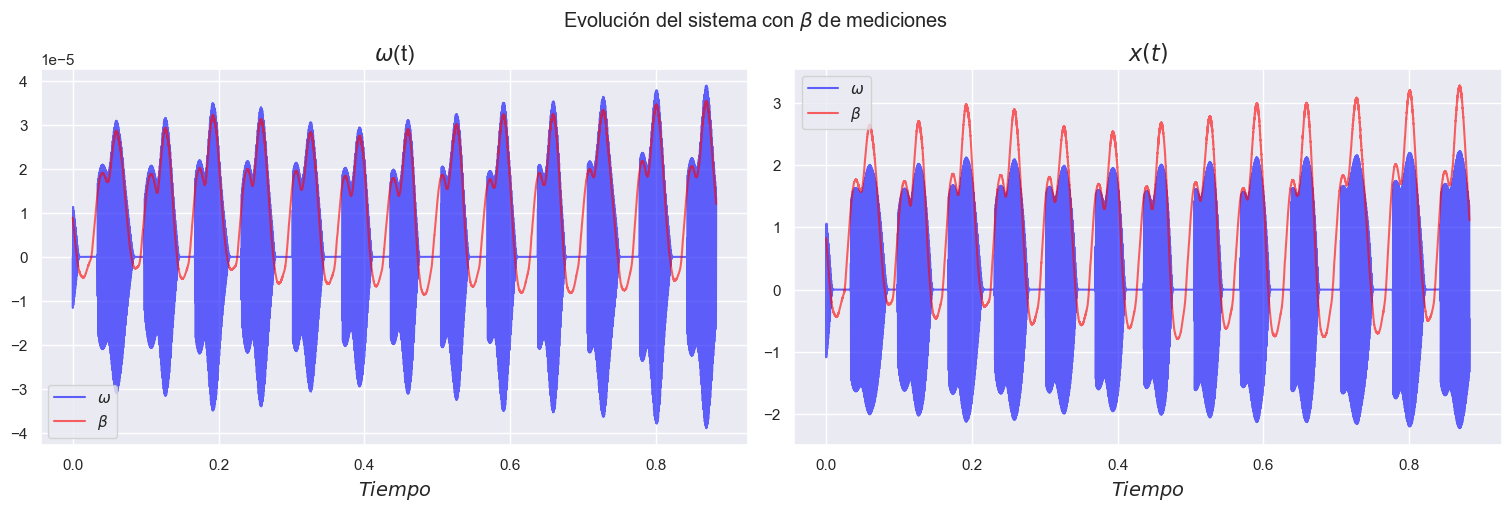

In [40]:
fig, [ax1, ax2] = plt.subplots(1, 2, figsize=(15,5), constrained_layout=True,
                                sharey=False)
#ploteo
ax1.plot(t,Xs[:,0][:-1],alpha = .60, color=colors[3], label = r'$\omega$')
ax1.plot(t,b_*max(Xs[:,0])/4,alpha = .60, color=colors[1], label = r'$\beta$')
ax1.legend(loc=0)

ax2.plot(t,Xs[:,1][:-1],alpha = .60, color=colors[3], label = r'$\omega$')
ax2.plot(t,b_/max(Xs[:,1])*2,alpha = .60, color=colors[1], label = r'$\beta$')
ax2. legend(loc=0)

ax1.set_xlabel('$Tiempo$', fontsize=14)
ax1.set_title(r'$\omega$(t)', fontsize=16)
ax2.set_xlabel('$Tiempo$', fontsize=14)
ax2.set_title(r'$x(t)$', fontsize=16)


fig.suptitle(r"Evolución del sistema con $\beta$ de mediciones")

comparo los datos de mediiciones con los de la simulación.
Para eso tengo que agarrar la cantidad de puntos de la medición

In [42]:
print(f'N de la simulacion: {len(t)} \n',f'N de los datos {len(t_m)} \n', f' Tomo de la simulación 1 dato cada {len(t)/len(t_m)}')

N de la simulacion: 780383 
 N de los datos 38976 
  Tomo de la simulación 1 dato cada 20.02214183087028


In [108]:
#t_ = [t[i] for i in range(len(t)) if i % 20 == 0]
t_s = []
s_s = []

s_sim = Xs[:,1]

for i in range(len(t)):
  if i % 20 == 0:
    t_s.append(t[i])
    s_s.append(s_sim[i])

print(len(t_s))
t_s = np.array(t_s[:len(t_m)]) #esto lo hago por el desfasaje de los dts!!! 
s_s = np.array(s_s[:len(t_m)])

s_m = s/5e3 #unidades!!! es un escaleo similar al que le hice antes al beta para poder comparar
print(len(t_s), len(s_s), len(t_m), len(s_m))

39020
38976 38976 38976 38976


En limpio las variables me quedaron:
t_s, t_m y s_s, s_m

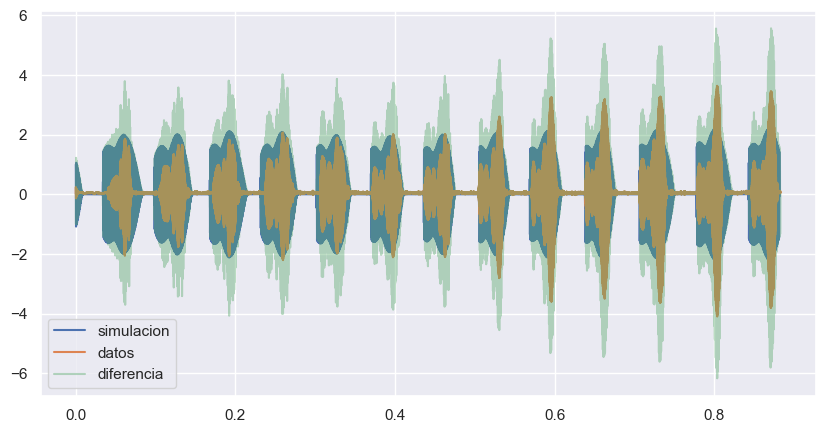

In [46]:
#unidades!!!

plt.figure(figsize=(10,5))
plt.plot(t_s,s_s, label = 'simulacion')
plt.plot(t_m,s_m, label = 'datos')
plt.plot(t_m,s_m-s_s,alpha = 0.4, label = 'diferencia') #sospecho que la diferencia es muy grande 
plt.legend()



### Filtro frecuencias
Voy a usar un filtro pasabajo para obtener el contorno de las señales y poder trabajar mejor.
Primero me quiero fijar aprox las frecuencias de $\beta$ para usar el filtro más eficientemente tener un estimado de las frecuencias que quiero tener

Text(0.5, 0, 'Frecuencia [Hz]')

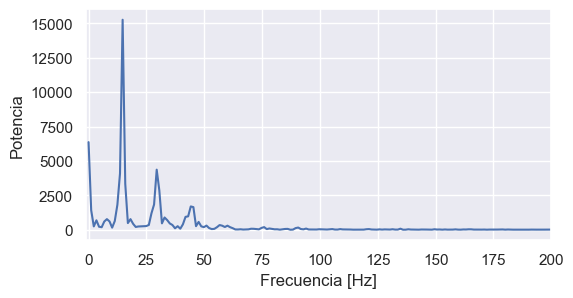

In [82]:

# Hago la FFT
fft = np.fft.fft(files[1]['presion'])

# tomo solo la primera mitad (y normalizo)
fft2 = 2.0/len(files[1]['presion']) * np.abs(fft[:len(files[1]['presion'])//2])
frecs2 = np.linspace(0, 44150/2, int(len(files[1]['presion'])/2)) #vector de frecuencias

# plot
fig, ax = plt.subplots(1,1,figsize=(6,3))
ax.plot(frecs2,np.abs(fft2))
ax.set_xlim([-1,200]) # Elijo (restrinjo) el eje horizontal
ax.set_ylabel('Potencia')
ax.set_xlabel('Frecuencia [Hz]')

usar un lockin acá no me serviría de mucho. podría poner un filtro pasabanda en ese rango de frecuencias?

In [178]:

def plot1(f_min, f_max):
    fig, (ax1, ax2) = plt.subplots(2, 1, sharex=True)
    ax1.plot(t_s, s_s)

    sos = signal.butter(6, [f_min, f_max], 'bandpass', fs=44150, output='sos')  #preguntar si el orden indicaba mas o menos abrupto el corte
    filtered = signal.sosfilt(sos, s_s)
    ax2.plot(t_s, filtered)
    ax2.set_title(f'Filtro de banda entre {f_min} y {f_max} Hz ')
    ax2.set_xlabel('Tiempo [s]')


#params
f_min = widgets.FloatSlider(value= 1 , min= 1 , max= 50, step= 1, description='f_min')
f_max = widgets.FloatSlider(value=50 , min= 1 , max= 60, step= 1, description='f_max')

# linkeo el slider con los graficos
output1 = widgets.interactive_output(plot1, {'f_min': f_min, 'f_max': f_max})

# muestro los outputs#
display(f_min, f_max, output1)


FloatSlider(value=1.0, description='f_min', max=50.0, min=1.0, step=1.0)

FloatSlider(value=50.0, description='f_max', max=60.0, min=1.0, step=1.0)

Output()

In [180]:

def plot1(f_min, f_max):
    fig, (ax1, ax2) = plt.subplots(2, 1, sharex=True)
    ax1.plot(t_m, s_m)

    sos = signal.butter(6, [f_min, f_max], 'bandpass', fs=44150, output='sos')  #preguntar si el orden indicaba mas o menos abrupto el corte
    filtered = signal.sosfilt(sos, s_m)
    ax2.plot(t_m, filtered)
    ax2.set_title(f'Filtro de banda entre {f_min} y {f_max} Hz ')
    ax2.set_xlabel('Tiempo [s]')


#params
f_min = widgets.FloatSlider(value= 1 , min= 1 , max= 50, step= 1, description='f_min')
f_max = widgets.FloatSlider(value=50 , min= 1 , max= 60, step= 1, description='f_max')

# linkeo el slider con los graficos
output1 = widgets.interactive_output(plot1, {'f_min': f_min, 'f_max': f_max})

# muestro los outputs#
display(f_min, f_max, output1)


FloatSlider(value=1.0, description='f_min', max=50.0, min=1.0, step=1.0)

FloatSlider(value=50.0, description='f_max', max=60.0, min=1.0, step=1.0)

Output()

preguntar por qué no funciona

13 13 1.0


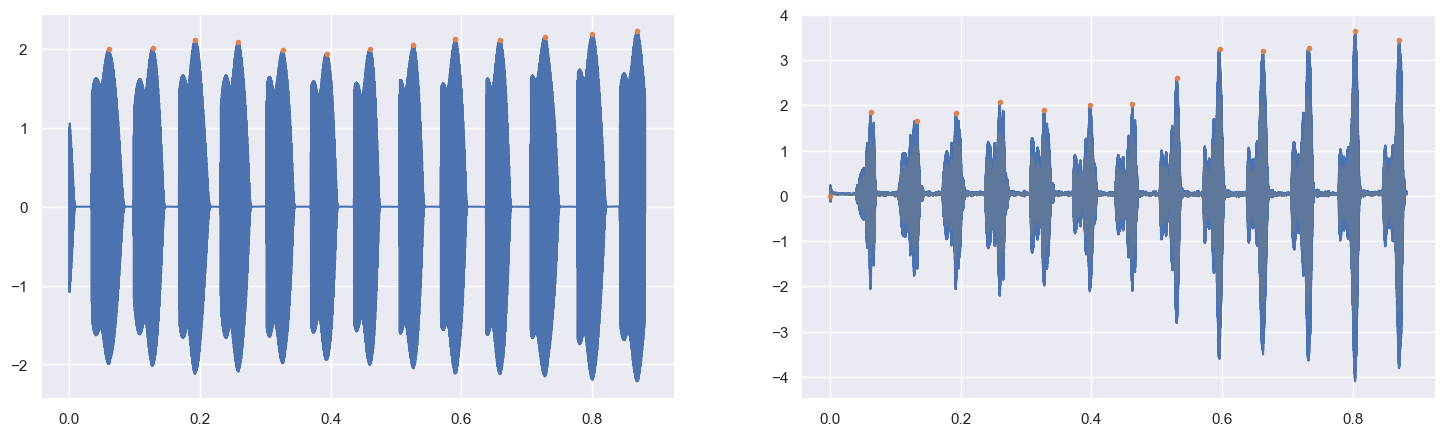

In [232]:
### Otra idea
fig, (ax1, ax2) = plt.subplots(1, 2, figsize = (18,5), sharex=True)

#busco picos
##simulacion
peaks_s, _ = signal.find_peaks(s_s, height = 1.7, prominence = 1, distance = 1000) #, threshold=0.1) #pruebo con el interpolado que tiene más puntos para ver

##medicion
peaks_m, _ = signal.find_peaks(s_m, height = 1.6, distance = 2e3 ) # np.abs(s_s_array/2)) #, threshold=0.1)


#ploteo
#ax1.plot(t_s, s_s)
#ax1.plot(t_s_array[peaks_s], s_s_array[peaks_s])
ax1.plot(t_s, s_s)
ax1.plot(t_s[peaks_s], s_s[peaks_s], '.')

ax2.plot(t_m, s_m)
ax2.plot(t_m[np.insert(peaks_m, 0, 0)], s_m[np.insert(peaks_m, 0, 0)], '.') # el insert es para la interpolacion
ax2.plot(t_s, s_m*2/3, '--', color = 'grey', alpha = .4)


print(len(s_s[peaks_s]),len(s_m[peaks_m]), len(s_m[peaks_m])/len(s_s[peaks_s]))

In [230]:
len(t_m)/14

2784.0

#### Primera aproximación
$\delta$ es una señal cuadrada que enciende y apaga el sistema.
Voy a calcular la diferencia entre las dos señales. Si me paso de cierto threshold considero que se apagó????


In [161]:
t_contorno = t_m[peaks_m]
s_m_contorno = s_m[peaks_m]

# calculo el rango de interpolacion (antes me tiraba error porque los limites de t_s_peaks eran mayor a los de t_m_peaks)
x_range = t_s[np.insert(peaks_s, [0,-1], [0,t_m[-1]])]
x_min, x_max = x_range.min(), x_range.max()

# defino t_contorno tal que este en el rango de la interpolacion
t_contorno_filtered = t_contorno[(t_contorno >= x_min) & (t_contorno <= x_max)]

#interpolo
interp_func_ = interp1d(t_s[np.insert(peaks_s, [0,-1], [0,t_m[-1]])], s_s[np.insert(peaks_s, [0,-1], [0,t_m[-1]])])

#t_s_contorno = np.linspace(0, t_s_array[peaks_s][-1], len(t_m_contorno))
s_s_contorno = interp_func_(t_contorno_filtered) # Use filtered t_contorno

interp_func_ = interp1d(t_s_array[np.insert(peaks_s, [0,-1], [0,t_m[-1]])], s_s[np.insert(peaks_s, [0,-1], [0,t_m[-1]])], fill_value="extrapolate")
s_s_contorno = interp_func_(t_contorno)

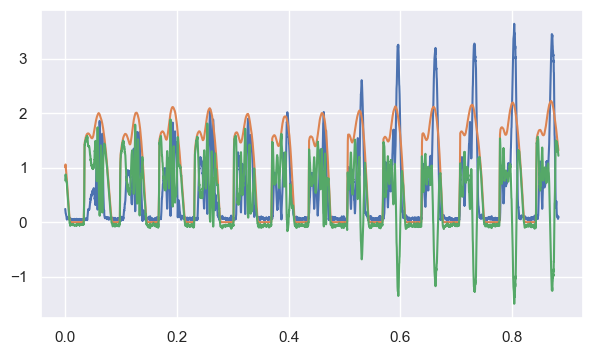

In [171]:
plt.figure(figsize= (7,4))
plt.plot(t_contorno, s_m_contorno)
plt.plot(t_contorno, s_s_contorno)
plt.plot(t_contorno, s_s_contorno - s_m_contorno)